In [3]:
__file__ = "run_fulll.ipynb"

In [4]:
"""Training script for training the weather forecasting model"""
import json
import os
import sys

sys.path.append(os.path.dirname(os.path.realpath(__file__)) + "/../")

from glob import glob
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import xarray as xr
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from graph_weather import GraphWeatherForecaster
from graph_weather.data import const
from graph_weather.models.losses import NormalizedMSELoss
import matplotlib.pyplot as plt


class XrDataset(Dataset):
    def __init__(self, file_name):
        super().__init__()

        self.data = xr.open_dataset(file_name, engine="netcdf4")

    def __len__(self):
        return len(self.data.time) - 1

    def __getitem__(self, idx):
        # start_idx = np.random.randint(0, len(self.data.time) - 1)
        data = self.data.isel(time=slice(idx, idx + 2))
        start = data.isel(time=0)
        end = data.isel(time=1)

        # if inter_data is not None and start != inter_data:
        #     start = inter_data
        #     end = data.isel(time=0)
        # elif start == inter_data:
        #     start = data.isel(time = 0)
        #     end = data.isel(time = 1)
        # else:
        #     start = data.isel(time=0)
        #     try:
        #         end = data.isel(time=1)
        #     except IndexError:
        #         inter_data = data.isel(time=0)

        # Stack the data into a large data cube
        input_data = np.stack(
            [
                (start[f"{var}"].values - const.FORECAST_MEANS[f"{var}"])
                / (const.FORECAST_STD[f"{var}"] + 0.0001)
                for var in start.data_vars
            ],
        )
        # input_data = np.stack(
        #     [(start[f"{var}"].values) for var in start.data_vars], axis=-1
        # )
        input_data = np.nan_to_num(input_data)

        assert not np.isnan(input_data).any()
        output_data = np.stack(
            [
                (end[f"{var}"].values - const.FORECAST_MEANS[f"{var}"])
                / (const.FORECAST_STD[f"{var}"] + 0.0001)
                for var in end.data_vars
            ]
        )
        # output_data = np.stack(
        #     [(end[f"{var}"].values) for var in end.data_vars], axis=-1
        # )
        output_data = np.nan_to_num(output_data)
        assert not np.isnan(output_data).any()
        transform = transforms.Compose([transforms.ToTensor()])
        # Normalize now
        return (
            transform(input_data)
            .transpose(0, 2)
            .transpose(1, 2)
            .reshape(-1, input_data.shape[0]),
            transform(input_data)
            .transpose(0, 2)
            .transpose(1, 2)
            .reshape(-1, input_data.shape[0]),
        )


data = xr.open_dataset(
    "../graph_weather/data/MERRA2_400.inst3_3d_asm_Nv.20230701_merged.nc",
    engine="netcdf4",
)
# print(data)
# print("Done coarsening")
# meshgrid takes in the lat and lon values, creates the arrays of every single latitude with the length of every single longitude, np.array reshapes it to get a matrix
# which contains the lat lon co-related values, eg. 90*180, 90*179.375 etc.
lat_lons = np.array(np.meshgrid(data.lat.values, data.lon.values)).T.reshape(-1, 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "mps" if torch.backends.mps.is_available() else "cpu"
# Get the variance of the variables
feature_variances = []
for var in data.data_vars:
    feature_variances.append(const.FORECAST_DIFF_STD[var] ** 2)
criterion = NormalizedMSELoss(
    lat_lons=lat_lons, feature_variance=feature_variances, device=device
).to(device)
# criterion = torch.nn.MSELoss().to(device)
means = []
# dataset = DataLoader(XrDataset(), batch_size=1)
# files_dataloader = DataLoader(FileDataset("graph_weather/data/train_data"), batch_size = 1)
model = GraphWeatherForecaster(lat_lons, feature_dim=65, num_blocks=6).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0000001)
print("Done Setup")
import time

train_files = glob("../graph_weather/data/train_data/*.nc", recursive=True)
val_files = glob("../graph_weather/data/val_data/*.nc", recursive=True)
running_loss, running_val_loss = [], []
for epoch in range(10):  # loop over the dataset multiple times
    model.train()
    start = time.time()
    inter_data = None
    running_loss_files = []
    running_val_loss_files = []
    for name in train_files:
        dataset = DataLoader(XrDataset(name), batch_size=1)

        # print(f"Start Epoch: {epoch+1}")
        for i, data in tqdm(enumerate(dataset), total=len(dataset), leave=False):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss_files.append(loss.item())
        print(f"{epoch + 1} training_loss: {np.mean(running_loss_files)}")

    model.eval()
    for name in val_files:
        dataset = DataLoader(XrDataset(name), batch_size=1)

        # print(f"Start Epoch: {epoch+1}")
        for i, data in tqdm(enumerate(dataset), total=len(dataset), leave=False):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # forward + backward + optimize
            outputs = model(inputs)

            val_loss = criterion(outputs, labels)

            # print statistics
            running_val_loss_files.append(val_loss.item())
            # print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}")
        print(f"{epoch + 1} validation_loss: {np.mean(running_val_loss_files)}")

    running_loss.append(np.mean(running_loss_files))
    running_val_loss.append(np.mean(running_val_loss_files))
end = time.time()
print(f"Time: {end - start} sec")

Done Setup


1 training_loss: 0.010722585687679904


1 training_loss: 0.010661069636366196


1 training_loss: 0.010600474308289233


1 training_loss: 0.010539043129288725


1 training_loss: 0.010478520020842551


1 training_loss: 0.010417767778216373


1 training_loss: 0.010357462915078717


1 training_loss: 0.010297593494345034


1 training_loss: 0.010237764138432722


1 training_loss: 0.010178409729685102


1 training_loss: 0.010120526415767607


1 training_loss: 0.01006268824095882


1 training_loss: 0.010005690577020356


1 training_loss: 0.009949027094990015


1 training_loss: 0.009892584560882477


1 training_loss: 0.009836990436139916


1 training_loss: 0.009781655299813808


1 training_loss: 0.009726533821473518


1 validation_loss: 0.008724019197481019


1 validation_loss: 0.008725664179239954


1 validation_loss: 0.008724160935907136


1 validation_loss: 0.008724204497411847


1 validation_loss: 0.008724419187222209


1 validation_loss: 0.008724446341927563


1 validation_loss: 0.008724995926782792


1 validation_loss: 0.008724966801569931


2 training_loss: 0.008676130058509963


2 training_loss: 0.008623875211924314


2 training_loss: 0.008572651206382684


2 training_loss: 0.00852158828638494


2 training_loss: 0.008469415988240922


2 training_loss: 0.008417255489066952


2 training_loss: 0.008365916449348537


2 training_loss: 0.008315063480819975


2 training_loss: 0.008264244031456728


2 training_loss: 0.008214187023362943


2 training_loss: 0.008165625063097709


2 training_loss: 0.008117782439859141


2 training_loss: 0.008070892853928464


2 training_loss: 0.008024637829702424


2 training_loss: 0.007979305128433875


2 training_loss: 0.007935059926239774


2 training_loss: 0.007891518556896378


2 training_loss: 0.007848702600255372


2 validation_loss: 0.007075564137526921


2 validation_loss: 0.007076801166736654


2 validation_loss: 0.007075913982199771


2 validation_loss: 0.007076082967354783


2 validation_loss: 0.007076401423130717


2 validation_loss: 0.007076560519635677


2 validation_loss: 0.007076949365817162


2 validation_loss: 0.007076937514024654


3 training_loss: 0.007043849543801376


3 training_loss: 0.007009926484897733


3 training_loss: 0.006976123566606215


3 training_loss: 0.00694295614292579


3 training_loss: 0.0069089236403150215


3 training_loss: 0.006874776301195934


3 training_loss: 0.006841423151520442


3 training_loss: 0.0068080889510123855


3 training_loss: 0.006774589049792479


3 training_loss: 0.006741053444732512


3 training_loss: 0.006708282965247507


3 training_loss: 0.006675663576017888


3 training_loss: 0.00664334886983692


3 training_loss: 0.006610954071071987


3 training_loss: 0.0065790603247781595


3 training_loss: 0.006547430164313742


3 training_loss: 0.006515962545204313


3 training_loss: 0.006484733081407963


3 validation_loss: 0.005915625885661159


3 validation_loss: 0.005916440593344825


3 validation_loss: 0.005915971761125894


3 validation_loss: 0.005916322781039136


3 validation_loss: 0.005916517241192716


3 validation_loss: 0.005916668268452797


3 validation_loss: 0.005916915187726216


3 validation_loss: 0.005916925529683275


4 training_loss: 0.00589145061426929


4 training_loss: 0.005864087758319718


4 training_loss: 0.00583603164358508


4 training_loss: 0.005808667479349034


4 training_loss: 0.005779840770576681


4 training_loss: 0.005750998843549972


4 training_loss: 0.005722938751687809


4 training_loss: 0.005695194055858467


4 training_loss: 0.005667619414568421


4 training_loss: 0.005640078116474407


4 training_loss: 0.005613397329126473


4 training_loss: 0.00558724588648017


4 training_loss: 0.005561567827608887


4 training_loss: 0.005536135328857571


4 training_loss: 0.005511465007882742


4 training_loss: 0.005487245819365073


4 training_loss: 0.0054635367504939315


4 training_loss: 0.0054403359129551855


4 validation_loss: 0.0050214556977152824


4 validation_loss: 0.005022481682577303


4 validation_loss: 0.005021896124595688


4 validation_loss: 0.0050222295768825075


4 validation_loss: 0.005022592988929578


4 validation_loss: 0.0050226641552788874


4 validation_loss: 0.005022910642152538


4 validation_loss: 0.005022909924654024


5 training_loss: 0.0050066992241357055


5 training_loss: 0.004990870099780815


5 training_loss: 0.0049738903263849875


5 training_loss: 0.004957859171554446


5 training_loss: 0.004941414615937642


5 training_loss: 0.004925128161197617


5 training_loss: 0.004909335036895105


5 training_loss: 0.004893837297069175


5 training_loss: 0.004878506057023529


5 training_loss: 0.00486312886433942


5 training_loss: 0.004848078008160576


5 training_loss: 0.004833194865135565


5 training_loss: 0.004818479550981914


5 training_loss: 0.004803741455306204


5 training_loss: 0.004789325342114482


5 training_loss: 0.004774933169496113


5 training_loss: 0.0047606420585838685


5 training_loss: 0.004746386326760763


5 validation_loss: 0.00448660080188087


5 validation_loss: 0.004487741771819336


5 validation_loss: 0.00448738918861463


5 validation_loss: 0.004487518636908915


5 validation_loss: 0.00448783336739455


5 validation_loss: 0.004487880561057301


5 validation_loss: 0.00448807835464879


5 validation_loss: 0.004488133684000266


6 training_loss: 0.004475390272481101


6 training_loss: 0.0044632604944386655


6 training_loss: 0.00444959569722414


6 training_loss: 0.004436292585783771


6 training_loss: 0.0044226452708244325


6 training_loss: 0.004408769143213119


6 training_loss: 0.004394905679688162


6 training_loss: 0.004380839095184845


6 training_loss: 0.004366653572235789


6 training_loss: 0.0043520379079771895


6 training_loss: 0.004337257905197995


6 training_loss: 0.004322289522471172


6 training_loss: 0.004307152503835303


6 training_loss: 0.004291743748080061


6 training_loss: 0.004276524337806872


6 training_loss: 0.00426112741115503


6 training_loss: 0.0042457131692404


6 training_loss: 0.004230310053875049


6 validation_loss: 0.003950065068368401


6 validation_loss: 0.003950919457046049


6 validation_loss: 0.003950746020390874


6 validation_loss: 0.003950788622855076


6 validation_loss: 0.003950887492724827


6 validation_loss: 0.003950914334771889


6 validation_loss: 0.003950977374856569


6 validation_loss: 0.003951021686329373


7 training_loss: 0.003937106113880873


7 training_loss: 0.003923932439647615


7 training_loss: 0.003909235454297492


7 training_loss: 0.0038952311650583787


7 training_loss: 0.003881066638444151


7 training_loss: 0.003866999110739146


7 training_loss: 0.0038534425132508788


7 training_loss: 0.003839883811971439


7 training_loss: 0.0038266400437033366


7 training_loss: 0.003813257617210703


7 training_loss: 0.003800077103804071


7 training_loss: 0.0037870843994564246


7 training_loss: 0.00377413407889205


7 training_loss: 0.003761217641948285


7 training_loss: 0.003748657904742729


7 training_loss: 0.0037360424466896802


7 training_loss: 0.0037235429964396134


7 training_loss: 0.0037112062989128015


7 validation_loss: 0.003487746131473354


7 validation_loss: 0.0034884688377912554


7 validation_loss: 0.003488201237771483


7 validation_loss: 0.0034882718713821043


7 validation_loss: 0.003488385384636266


7 validation_loss: 0.003488464874126727


7 validation_loss: 0.0034885059053800546


7 validation_loss: 0.003488587776830952


8 training_loss: 0.0034776393856321064


8 training_loss: 0.0034679395113406436


8 training_loss: 0.0034566220960446765


8 training_loss: 0.00344598077936098


8 training_loss: 0.003435053975720491


8 training_loss: 0.0034242517070933467


8 training_loss: 0.0034138350509943403


8 training_loss: 0.0034034865259725067


8 training_loss: 0.003393350915598964


8 training_loss: 0.0033830707826252495


8 training_loss: 0.003372920350498193


8 training_loss: 0.0033629126763636513


8 training_loss: 0.003352870688783926


8 training_loss: 0.0033429145470869784


8 training_loss: 0.003333214512981829


8 training_loss: 0.00332343893075761


8 training_loss: 0.0033137481953134807


8 training_loss: 0.003304168336196906


8 validation_loss: 0.003130602018375482


8 validation_loss: 0.00313129197872643


8 validation_loss: 0.0031309762659172216


8 validation_loss: 0.003131052736924695


8 validation_loss: 0.003131150141624468


8 validation_loss: 0.003131227811709756


8 validation_loss: 0.003131269505817671


8 validation_loss: 0.003131372342717701


9 training_loss: 0.0031225131159382208


9 training_loss: 0.003114787262997457


9 training_loss: 0.0031058755814142172


9 training_loss: 0.0030975298141129315


9 training_loss: 0.003088970508958612


9 training_loss: 0.00308043765835464


9 training_loss: 0.0030722505346472773


9 training_loss: 0.0030641854100394994


9 training_loss: 0.0030562513995738257


9 training_loss: 0.00304823107019599


9 training_loss: 0.0030403304966045664


9 training_loss: 0.003032550986279689


9 training_loss: 0.003024725187160484


9 training_loss: 0.003017009414105239


9 training_loss: 0.0030094972390326716


9 training_loss: 0.0030019165424164385


9 training_loss: 0.002994400527359558


9 training_loss: 0.00298699605396934


9 validation_loss: 0.0028525927170578924


9 validation_loss: 0.0028530745268134134


9 validation_loss: 0.0028528235630974883


9 validation_loss: 0.0028528846451081336


9 validation_loss: 0.0028529530989804437


9 validation_loss: 0.002852997288019175


9 validation_loss: 0.0028530019097866453


9 validation_loss: 0.002853074676490256


10 training_loss: 0.0028461106454155277


10 training_loss: 0.00284004703696285


10 training_loss: 0.002833092574118858


10 training_loss: 0.0028264318077292827


10 training_loss: 0.0028196024908018966


10 training_loss: 0.002812695733848072


10 training_loss: 0.002806014443120482


10 training_loss: 0.002799381485341915


10 training_loss: 0.002792786962042252


10 training_loss: 0.0027861055286069


10 training_loss: 0.002779432926206039


10 training_loss: 0.0027728622025322345


10 training_loss: 0.002766215436897435


10 training_loss: 0.0027596401454576727


10 training_loss: 0.0027531858733189957


10 training_loss: 0.0027466635157387437


10 training_loss: 0.0027401807087966625


10 training_loss: 0.002733788002164118


10 validation_loss: 0.0026177308921303067


10 validation_loss: 0.002617959797914539


10 validation_loss: 0.0026176925305099715


10 validation_loss: 0.0026177881102609846


10 validation_loss: 0.002617827184232218


10 validation_loss: 0.002617819279077507


10 validation_loss: 0.0026178078782953776


10 validation_loss: 0.0026178245565720965
Time: 5995.853513240814 sec


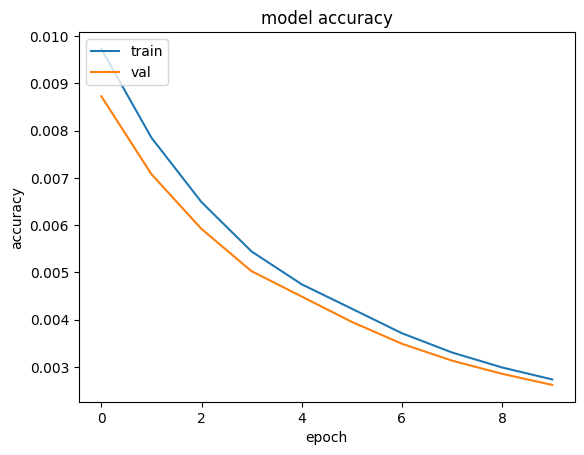

In [5]:
plt.plot(running_loss)
plt.plot(running_val_loss)
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
# plt.savefig("openweather_20epochs_merra_batch_2.png")
# plt.show()

In [6]:
test_dir = glob("../graph_weather/data/test_data/*.nc", recursive=True)
test_dir

['../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230718_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230720_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230726_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230719_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230721_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230722_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230717_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230724_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230723_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230725_merged.nc']

In [10]:
class XrDataset(Dataset):
    def __init__(self, file_name):
        super().__init__()

        self.data = xr.open_dataset(file_name, engine="netcdf4")

    def __len__(self):
        return len(self.data.time) - 1

    def __getitem__(self, idx):
        # start_idx = np.random.randint(0, len(self.data.time) - 1)
        data = self.data.isel(time=slice(idx, idx + 2))
        start = data.isel(time=0)
        end = data.isel(time=1)

        # if inter_data is not None and start != inter_data:
        #     start = inter_data
        #     end = data.isel(time=0)
        # elif start == inter_data:
        #     start = data.isel(time = 0)
        #     end = data.isel(time = 1)
        # else:
        #     start = data.isel(time=0)
        #     try:
        #         end = data.isel(time=1)
        #     except IndexError:
        #         inter_data = data.isel(time=0)

        # Stack the data into a large data cube
        input_data = np.stack(
            [
                (start[f"{var}"].values)
                for var in start.data_vars
            ],
        )
        # input_data = np.stack(
        #     [(start[f"{var}"].values) for var in start.data_vars], axis=-1
        # )
        input_data = np.nan_to_num(input_data)

        assert not np.isnan(input_data).any()
        output_data = np.stack(
            [
                (end[f"{var}"].values)
                for var in end.data_vars
            ]
        )
        # output_data = np.stack(
        #     [(end[f"{var}"].values) for var in end.data_vars], axis=-1
        # )
        output_data = np.nan_to_num(output_data)
        assert not np.isnan(output_data).any()
        transform = transforms.Compose([transforms.ToTensor()])
        # Normalize now
        return (
            transform(input_data)
            .transpose(0, 2)
            .transpose(1, 2)
            .reshape(-1, input_data.shape[0]),
            transform(input_data)
            .transpose(0, 2)
            .transpose(1, 2)
            .reshape(-1, input_data.shape[0]),
        )

In [11]:
dataset = DataLoader(XrDataset(test_dir[0]), batch_size= 1)

In [12]:
items = iter(dataset)
inputs, labels = next(items)

In [13]:
inputs, labels = inputs.to(device), labels.to(device)
outputs_test = model(inputs)
diff_test = labels - outputs_test

python(3864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Text(0.5, 1.0, 'Difference in actual output and prediction')

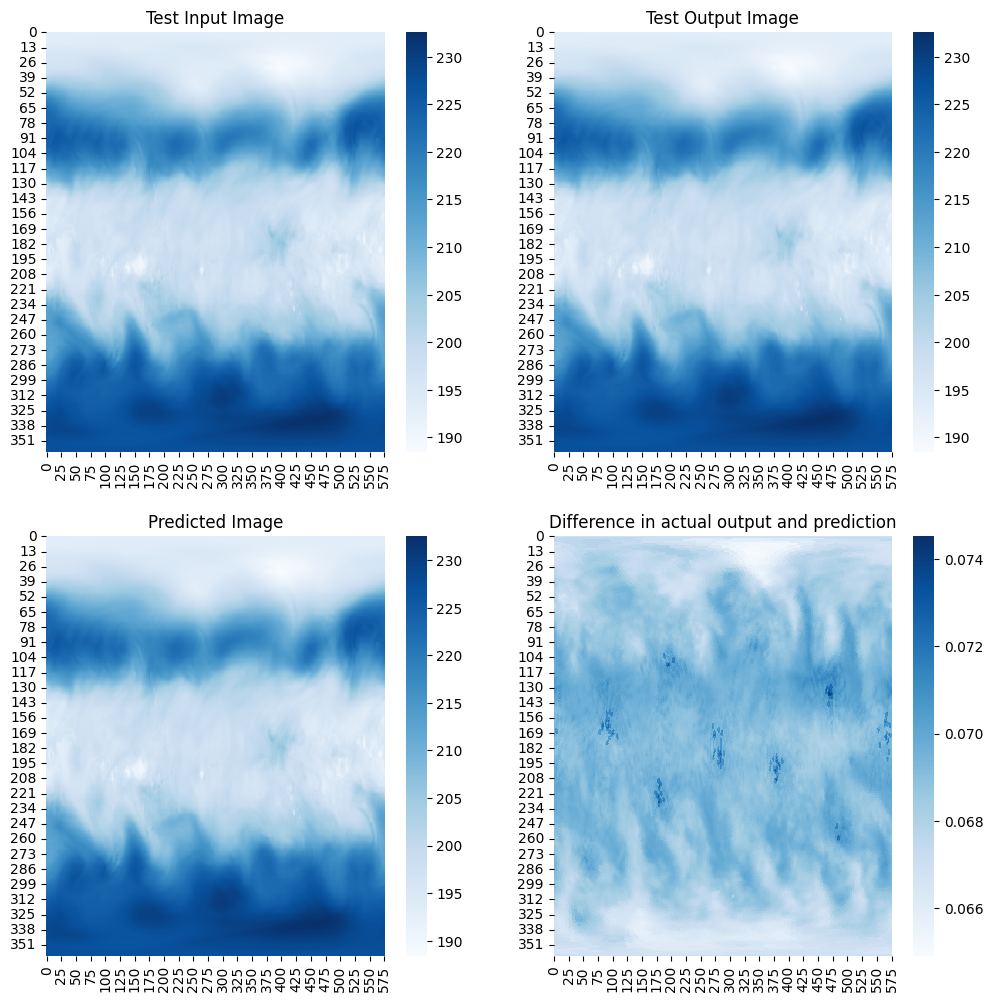

In [15]:
import seaborn as sns
fig1, ax1 = plt.subplots(2, 2, figsize=(12, 12))
sns.heatmap(torch.reshape(inputs, (1, 361, 576, 65))[0, :, :, 27], cbar = True, cmap = 'Blues', ax = ax1[0][0])
ax1[0][0].set_title("Test Input Image")

sns.heatmap(torch.reshape(labels, (1, 361, 576, 65))[0, :, :, 27], cbar = True, cmap = 'Blues', ax = ax1[0][1])
ax1[0][1].set_title("Test Output Image")

sns.heatmap(torch.reshape(outputs_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 27], cmap = 'Blues', cbar= True, ax = ax1[1][0])
ax1[1][0].set_title("Predicted Image")

sns.heatmap(torch.reshape(diff_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 27], cmap = 'Blues', cbar = True, ax = ax1[1][1])
ax1[1][1].set_title("Difference in actual output and prediction")

Text(0.5, 1.0, 'Difference in actual output and prediction')

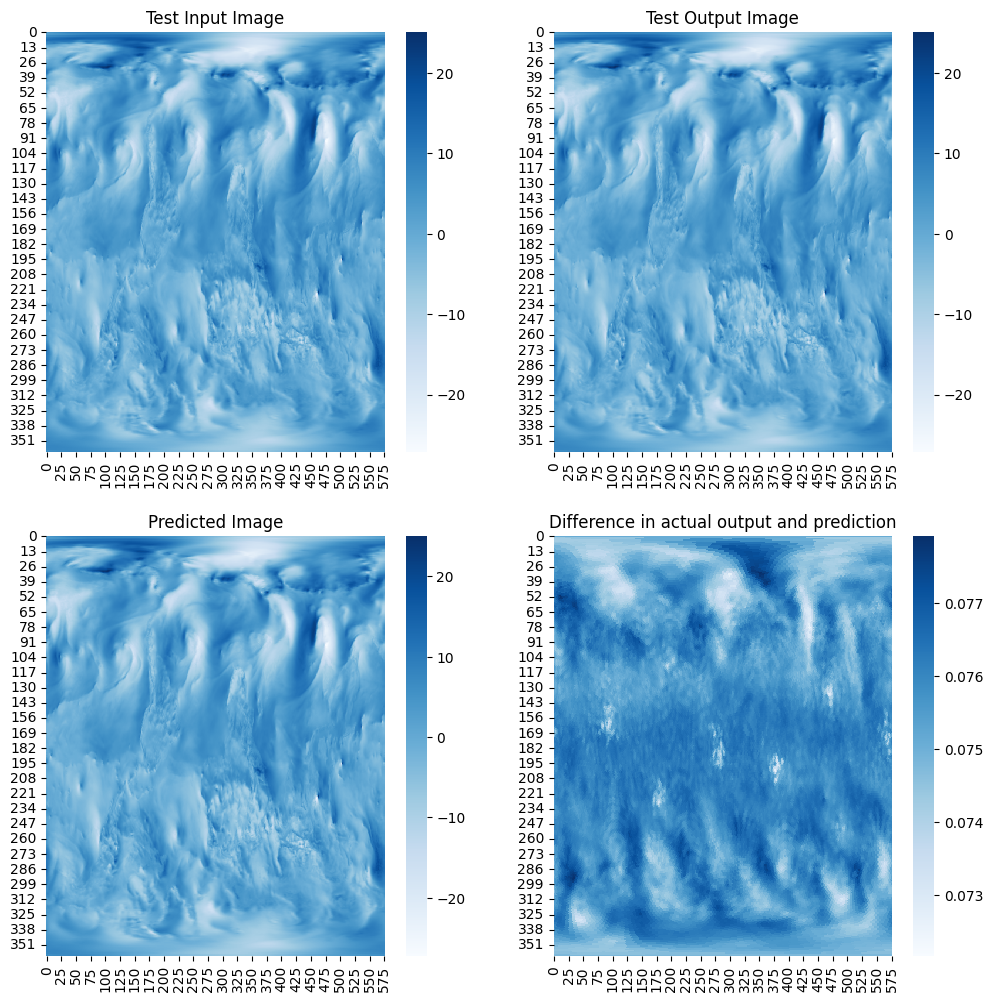

In [16]:
fig1, ax1 = plt.subplots(2, 2, figsize=(12, 12))
sns.heatmap(torch.reshape(inputs, (1, 361, 576, 65))[0, :, :, 64], cbar = True, cmap = 'Blues', ax = ax1[0][0])
ax1[0][0].set_title("Test Input Image")

sns.heatmap(torch.reshape(labels, (1, 361, 576, 65))[0, :, :, 64], cbar = True, cmap = 'Blues', ax = ax1[0][1])
ax1[0][1].set_title("Test Output Image")

sns.heatmap(torch.reshape(outputs_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 64], cmap = 'Blues', cbar= True, ax = ax1[1][0])
ax1[1][0].set_title("Predicted Image")

sns.heatmap(torch.reshape(diff_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 64], cmap = 'Blues', cbar = True, ax = ax1[1][1])
ax1[1][1].set_title("Difference in actual output and prediction")

In [17]:
inputs

tensor([[[ 4.2614e-03,  1.9821e-02,  1.2112e-02,  ...,  1.0064e+01,
           9.9610e+00,  3.7319e+00],
         [ 4.2614e-03,  1.9821e-02,  1.2112e-02,  ...,  1.0131e+01,
           1.0035e+01,  3.8549e+00],
         [ 4.2614e-03,  1.9821e-02,  1.2112e-02,  ...,  1.0197e+01,
           1.0109e+01,  3.9760e+00],
         ...,
         [-4.6026e-04, -3.8449e-03, -6.9307e-03,  ...,  7.8220e+00,
           7.9767e+00,  6.2573e+00],
         [-4.6026e-04, -3.8449e-03, -6.9307e-03,  ...,  7.8415e+00,
           8.0001e+00,  6.2944e+00],
         [-4.6026e-04, -3.8449e-03, -6.9307e-03,  ...,  7.8572e+00,
           8.0235e+00,  6.3295e+00]]])

In [ ]:
for name in glob("graph_weather/data/test_data/*.nc", recursive=True):
    dataset = DataLoader(XrDataset(name), batch_size=1)
    fig1, ax1 = plt.subplots(2, 2, figsize=(12, 12))
    fig1.suptitle("Test Image")
    for i, data in tqdm(enumerate(dataset), total=len(dataset), leave=False):
        # get the inputs; data is a list of [inputs, labels]
        inputs_test, labels = data[0].to(device), data[1].to(device)
        ax1[0][0].imshow(torch.reshape(inputs_test, (1, 361, 576, 65))[0, :, :, 27])
        ax1[0][0].set_title("Test Input Image")

        ax1[0][1].imshow(torch.reshape(labels, (1, 361, 576, 65))[0, :, :, 27])
        ax1[0][1].set_title("Test Output Image")
        # zero the parameter gradients
        # forward + backward + optimize
        outputs_test = model(inputs_test)
        ax1[1][0].imshow(
            torch.reshape(outputs_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 27]
        )
        ax1[1][0].set_title("Predicted Image")

        diff_test = labels - outputs_test

        ax1[1][1].imshow(
            torch.reshape(diff_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 27]
        )
        ax1[1][1].set_title("Difference in actual output and prediction")

        plt.savefig(f"results_{name.split('/')[-1][:-3]}_{i}_prediction.png")